In [7]:
from neucube import Reservoir
from neucube.encoder import RateEncoder, Deltav2
from neucube.validation import Pipeline
from neucube.sampler import SpikeCount
from neucube.datamanager import DataManager
import pandas as pd
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
params = {
            'source_data_path': 'example_data/labquake_source',
            'samples_path':'example_data/labquake_samples',
            'sampling_rate': 5000,
            'batch_duration': 8000,
    
        }
datamanager = DataManager(params)

In [3]:
filenameslist = ['sample_'+str(idx)+'.csv' for idx in range(100,300)]

dfs = []
for filename in filenameslist:
  dfs.append(pd.read_csv('./example_data/labquake_samples/'+filename, header=0))

fulldf = pd.concat(dfs)

In [4]:
def compute_negative_moving_average_derivatives(dataset, window_size):
    """
    Computes the negative of the moving average derivatives for the entire dataset.

    Args:
        dataset (torch.Tensor): Input dataset, shape (batch_size, time_steps, num_features)
        window_size (int): Window size for the moving average filter.

    Returns:
        torch.Tensor: Negative moving average derivatives, shape (batch_size, time_steps, num_features)
    """
    batch_size, time_steps, num_features = dataset.shape
    all_negative_derivatives = []

    # Instantiate a temporary RateEncoder to use its moving_average method
    temp_encoder = RateEncoder(min_values=None, max_values=None, window_size=window_size)

    for i in range(batch_size):
        sample_negative_derivatives = []
        for j in range(num_features):
            sample = dataset[i][:, j]  # Shape: (time_steps,)

            # Compute derivative with same size
            derivative = torch.zeros_like(sample)
            derivative[1:] = sample[1:] - sample[:-1]
            derivative[0] = 0  # Handle as appropriate

            # Apply moving average
            smoothed_derivative = temp_encoder.moving_average(derivative)

            # Take the negative of the smoothed derivative
            negative_derivative = -smoothed_derivative

            sample_negative_derivatives.append(negative_derivative)

        sample_negative_derivatives = torch.stack(sample_negative_derivatives, dim=1)  # Shape: (time_steps, num_features)
        all_negative_derivatives.append(sample_negative_derivatives)

    all_negative_derivatives = torch.stack(all_negative_derivatives, dim=0)  # Shape: (batch_size, time_steps, num_features)
    return all_negative_derivatives

def compute_thresholds(negative_derivatives, percentile):
    """
    Computes thresholds for each feature based on the given percentile of the negative derivatives.

    Args:
        negative_derivatives (torch.Tensor): Negative moving average derivatives, shape (num_samples, num_features)
        percentile (float): Percentile value (between 0 and 100) to compute thresholds.

    Returns:
        torch.Tensor: Thresholds for each feature, shape (num_features,)
    """
    # Convert to numpy array for percentile computation
    negative_derivatives_np = negative_derivatives.numpy()

    thresholds = []
    for i in range(negative_derivatives_np.shape[1]):
        feature_data = negative_derivatives_np[:, i]
        threshold = np.percentile(feature_data, percentile)
        thresholds.append(threshold)
    thresholds = torch.tensor(thresholds)
    return thresholds


In [5]:
fulldf

,Channel_1,Channel_2,Channel_3,Channel_4,Channel_5,Channel_6,Channel_7,Channel_8,Channel_9,Channel_10,...,Channel_16,Channel_17,Channel_18,Channel_19,Channel_20,Channel_21,Channel_22,Channel_23,Channel_24,Channel_25
0,1.736875,3.320625,0.010378,0.003253,0.004722,0.000159,0.004534,0.008156,0.015567,-9.472812,...,-8.834375,-14.039687,1.738750,1.047969,-15.883750,0.000117,0.000477,0.000156,0.000086,0.000258
1,1.737344,3.320625,0.010389,0.003259,0.004723,0.000153,0.004523,0.008144,0.015556,-9.473125,...,-8.835312,-14.039687,1.738984,1.047422,-15.885937,0.000109,0.000445,0.000133,0.000086,0.000250
2,1.737656,3.320547,0.010392,0.003244,0.004714,0.000169,0.004523,0.008159,0.015570,-9.473438,...,-8.835938,-14.040625,1.737891,1.048516,-15.887500,0.000125,0.000414,0.000047,0.000063,0.000203
3,1.738281,3.320625,0.010392,0.003258,0.004734,0.000141,0.004514,0.008153,0.015562,-9.473750,...,-8.837187,-14.041875,1.738281,1.048281,-15.889375,0.000359,0.000500,0.000164,0.000117,0.000258
4,1.737266,3.320625,0.010383,0.003266,0.004717,0.000167,0.004514,0.008147,0.015562,-9.474063,...,-8.837187,-14.042500,1.738750,1.046797,-15.890625,0.000203,0.000453,0.000125,0.000078,0.000242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1.634766,3.517500,0.009075,0.002895,0.004253,-0.000978,0.003856,0.007566,0.014214,-18.109375,...,-15.316562,-16.087500,1.636250,1.008750,-16.416875,0.000109,0.000422,0.000117,0.000055,0.000203
396,1.635469,3.517422,0.009050,0.002898,0.004252,-0.000964,0.003844,0.007545,0.014219,-18.109375,...,-15.317187,-16.087500,1.636406,1.010625,-16.418125,0.000117,0.000430,0.000117,0.000070,0.000227
397,1.634141,3.517422,0.009073,0.002887,0.004275,-0.000959,0.003870,0.007567,0.014203,-18.108750,...,-15.317187,-16.087500,1.635547,1.009844,-16.417500,0.000414,0.000492,0.000188,0.000117,0.000305
398,1.634609,3.517500,0.009070,0.002892,0.004241,-0.000966,0.003852,0.007572,0.014205,-18.110000,...,-15.317813,-16.087187,1.634688,1.010000,-16.418125,0.000031,0.000383,0.000078,0.000023,0.000195


In [11]:
X = torch.tensor(fulldf.values.reshape(200, 400, 25))  # Adjust dimensions as per your dataset

# Compute negative moving average derivatives
negative_moving_avg_derivatives = compute_negative_moving_average_derivatives(X, window_size=10)

# Reshape to a 2D tensor for percentile computation
reshaped_negative_derivatives = negative_moving_avg_derivatives.view(-1, X.shape[2])  # Shape: (batch_size * time_steps, num_features)

# Compute thresholds for each feature at the desired percentile (e.g., 99th percentile)
percentile_value = 90.0  # Change as needed
thresholds = compute_thresholds(reshaped_negative_derivatives, percentile=percentile_value)

encoder = Deltav2(thresholds)
encoded_dataset = encoder.encode_dataset(X)

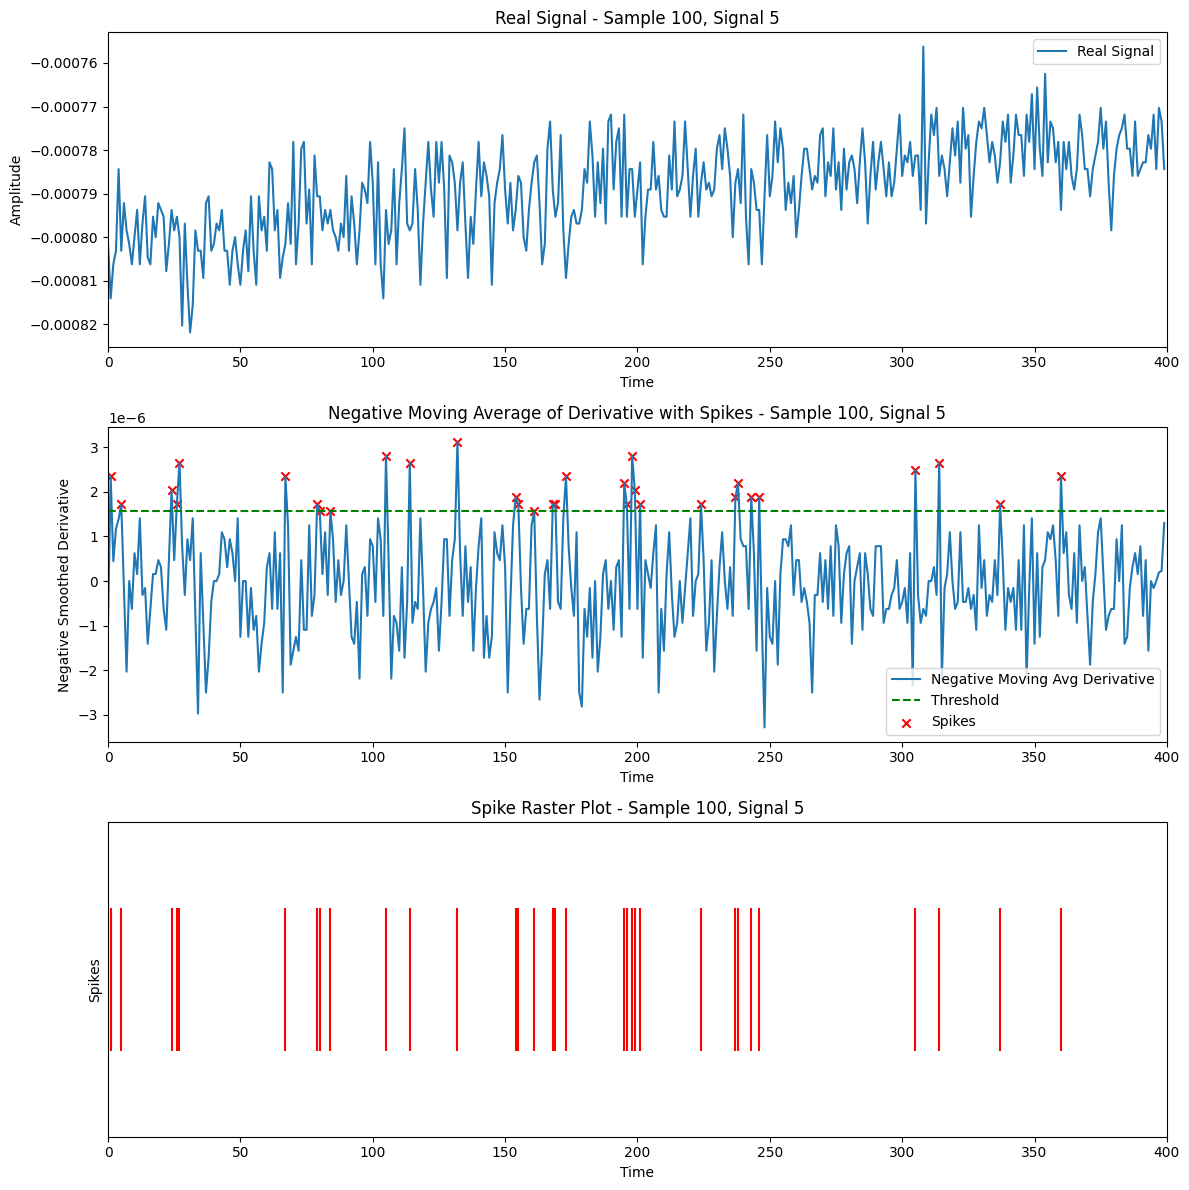

In [14]:
import torch
import matplotlib.pyplot as plt

def moving_average(data, window_size=10):
    if window_size < 2:
        return data
    data = data.float().unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, sequence_length]
    padding = window_size // 2
    smoothed_data = torch.nn.functional.avg_pool1d(
        data,
        kernel_size=window_size,
        stride=1,
        padding=padding,
        count_include_pad=False
    )
    smoothed_data = smoothed_data.squeeze(0).squeeze(0)
    return smoothed_data[:data.shape[-1]]

def plot_signal_and_encoding(X, encoded_dataset, thresholds, sample_index, signal_index, window_size=10):
    plt.figure(figsize=(12, 12))

    # Get the x-axis limits (time steps)
    xlim = (0, X.shape[1])

    # Plotting the real signal
    plt.subplot(3, 1, 1)
    plt.plot(X[sample_index, :, signal_index], label='Real Signal')
    plt.xlim(xlim)  # Set x-axis limits
    plt.title(f'Real Signal - Sample {sample_index}, Signal {signal_index}')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.legend()

    # Calculating and plotting the negative moving average derivative
    plt.subplot(3, 1, 2)
    # Compute the derivative with the same size as in the encoder
    sample_signal = X[sample_index, :, signal_index]
    derivative = torch.zeros_like(sample_signal)
    derivative[1:] = sample_signal[1:] - sample_signal[:-1]
    derivative[0] = derivative[1]  # Adjusted to match the encoder

    # Apply moving average
    moving_avg_derivative = moving_average(derivative, window_size)

    # Take the negative of the moving average derivative
    negative_moving_avg_derivative = -moving_avg_derivative

    # Plot the negative moving average derivative
    plt.plot(negative_moving_avg_derivative, label='Negative Moving Avg Derivative')

    # Get the threshold for the current feature
    threshold = thresholds[signal_index].item()

    # Plot the threshold line
    plt.axhline(y=threshold, color='green', linestyle='--', label='Threshold')

    # Overlay the spike times
    spike_times_neg = torch.where(encoded_dataset[sample_index, :, signal_index] == 1)[0]
    spike_values = negative_moving_avg_derivative[spike_times_neg]
    plt.scatter(spike_times_neg, spike_values, color='red', marker='x', label='Spikes')

    plt.xlim(xlim)  # Set x-axis limits
    plt.title(f'Negative Moving Average of Derivative with Spikes - Sample {sample_index}, Signal {signal_index}')
    plt.xlabel('Time')
    plt.ylabel('Negative Smoothed Derivative')
    plt.legend()

    # Plotting the spike raster
    plt.subplot(3, 1, 3)
    plt.eventplot(spike_times_neg.numpy(), orientation='horizontal', colors='red', linelengths=1)
    plt.xlim(xlim)  # Set x-axis limits
    plt.title(f'Spike Raster Plot - Sample {sample_index}, Signal {signal_index}')
    plt.xlabel('Time')
    plt.ylabel('Spikes')
    plt.yticks([])  # Hide y-axis labels since there's only one line

    plt.tight_layout()
    plt.show()

# Example usage: plot signal and encoding for sample 125, signal 2
# Make sure to pass the thresholds used in the encoder
plot_signal_and_encoding(X, encoded_dataset, thresholds, sample_index=100, signal_index=5, window_size=10)
